In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [2]:
# activate line execution
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from plotly.subplots import make_subplots

import plotly.express as px
import plotly.graph_objects as go

In [4]:
import pandas as pd
import os
import numpy as np

import pickle

In [5]:
add = "../../hkgan/data/synthetic_data_irreg_inhom.pkl"
with open(add, "rb") as f:
    data = pickle.load(f)

In [6]:
len(data)
data[0][-1]
data[0][0]

2048

{'Label': 0}

{'ts': array([  0,   1,   3,   5,   7,   8,   9,  11,  13,  14,  16,  17,  18,
         19,  20,  21,  25,  26,  28,  29,  31,  32,  33,  34,  36,  39,
         41, 109, 110, 113, 118, 124, 129, 131, 205, 229, 328, 412, 444,
        454, 523, 624, 648]),
 'y': array([ 0.00298897,  0.03738373,  0.08451859,  0.13987749,  0.18512748,
         0.20784633,  0.20704749,  0.27788329,  0.31693402,  0.33074591,
         0.35314654,  0.37644079,  0.3904015 ,  0.39635998,  0.39156711,
         0.41243742,  0.40969681,  0.42480467,  0.41952994,  0.4158829 ,
         0.40879987,  0.40806465,  0.37440487,  0.37642474,  0.32789059,
         0.26497557,  0.2240931 ,  0.22045627,  0.26846824,  0.31306767,
         0.39829393,  0.43109024,  0.41324902,  0.38702617,  0.13954087,
         0.43254889,  0.41415822,  0.29293604,  0.15869984, -0.11070698,
         0.42843716,  0.44424716,  0.0489893 ])}

In [7]:
sta = pd.DataFrame(data=[x[-1] for x in data], columns=["Label"])
sta
sta.Label.sum()

Label
0         0
1         0
2         0
3         0
4         0
...     ...
2043      1
2044      1
2045      1
2046      1
2047      1

[2048 rows x 1 columns]

1024

In [8]:
n_samples = len(data)
dyn = []
for i in range(n_samples):
    t1 = data[i][0]['ts']
    sig1 = data[i][0]['y']
    t2 = data[i][1]['ts']
    sig2 = data[i][1]['y']
    t= np.concatenate((t1,t2))
    sig = np.concatenate((sig1,sig2))
    name = np.concatenate((np.repeat('S1',len(t1)),np.repeat('S2',len(t2))))
    # t.shape, sig.shape, name.shape
    
    temp = pd.DataFrame(data={'time':t, 'value':sig,'name':name})
    # temp.head()
    temp = temp.pivot(index='time', columns='name', values='value').reset_index()
    temp.columns.name = None
    # temp.head()

    dyn.append(temp)


In [9]:
len(dyn)
dyn[0]

2048

time        S1        S2
0      0  0.002989       NaN
1      1  0.037384  0.011726
2      3  0.084519  0.015847
3      4       NaN  0.049969
4      5  0.139877       NaN
..   ...       ...       ...
77   648  0.048989       NaN
78   662       NaN  0.412798
79   663       NaN  0.413791
80   677       NaN  0.280050
81   681       NaN  0.244082

[82 rows x 3 columns]

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00024414, 0.00708008, 0.03942871, 0.05151367,
        0.0222168 , 0.00427246, 0.00024414, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
        176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.,
        264., 272., 280., 288., 296., 304., 312., 320., 328., 336., 344.,
        352., 360., 36

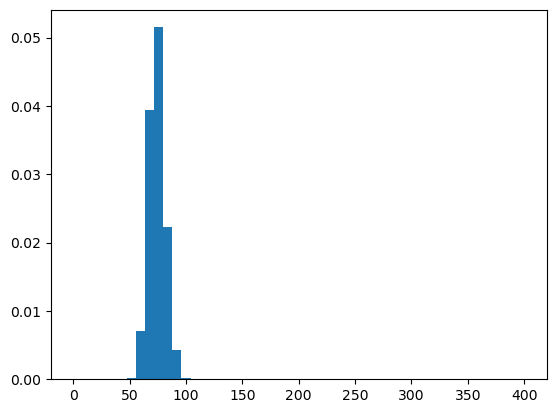

In [10]:
sta_types = ['binary',"int"]
dyn_types = ['continuous']*len(dyn[0].columns)
dynamics = pd.concat(dyn)
seq_len = [len(x) for x in dyn]
sta["seq_len"]=np.array(seq_len)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(seq_len, range=(0,400), bins=50, density=True)
plt.show()

In [11]:
from general.missingprocessor import Processor
d_P = Processor(dyn_types, use_pri='time')
s_P = Processor(sta_types)
d_P.fit(dynamics)
s_P.fit(sta)

all values are integer
time 1 None int None
IGNORE
S1 1 0.47002015783718265 continuous None
IGNORE
S2 1 0.44054755536817697 continuous None
IGNORE
Label 1 None binary None
seq_len 1 None int None
IGNORE


In [12]:
def build_dataset(sta, dyn, seq_len):
    s = s_P.transform(sta)
    d_lis=[d_P.transform(ds) for ds in dyn]
    d = [x[0].tolist() for x in d_lis]
    lag = [x[1].tolist() for x in d_lis]
    mask = [x[2].tolist() for x in d_lis]
    times = [x[-1].tolist() for x in d_lis]
    priv = [x[3].tolist() for x in d_lis]
    nex = [x[4].tolist() for x in d_lis]
    label = [float(x[-2]) for x in s] 

    # # # compute dt from absolute time
    # # list_dt = []
    # # for i in range(len(dyn)):
    # #     # times = np.array(dataset[i]['times'])
    # #     abs_time = dyn[i].time.values
    # #     dt = np.diff(abs_time,prepend=0)
    # #     list_dt.append(dt)
    # # value_max = max([max(x) for x in list_dt])
    # # value_min = min([min(x) for x in list_dt])
    # # value_mean = np.mean([np.mean(x) for x in list_dt])
    # # value_std = np.std([np.std(x) for x in list_dt])
    # # print('HI',value_max, value_min, value_mean, value_std)

    # # list_dt = [((x-value_min)/value_max) for x in list_dt]
    # # # list_dt = [(x-value_mean)/value_std for x in list_dt]



    # compute dt from normalized time
    list_dt = []
    for i in range(len(times)):
        norm_time = np.array(times[i]).flatten()
        # abs_time = dyn[i].time.values
        dt = np.diff(norm_time,prepend=norm_time[0].item())[:,None]
        list_dt.append(dt)
    value_max = max([max(x) for x in list_dt])
    value_min = min([min(x) for x in list_dt])
    value_mean = np.mean([np.mean(x) for x in list_dt])
    value_std = np.std([np.std(x) for x in list_dt])
    print('HI',value_max, value_min, value_mean, value_std)

    list_dt = [((x-value_min)/value_max) for x in list_dt]
    # list_dt = [(x-value_mean)/value_std for x in list_dt]



    from fastNLP import DataSet
    dataset = DataSet({"seq_len": seq_len, 
                       "dyn": d, "lag":lag, "mask": mask,
                       "sta": s, "times":times, "priv":priv, "nex":nex, "label": label,
                        "dt": list_dt
                      })
    return dataset, list_dt

dataset, list_dt = build_dataset(sta, dyn, seq_len)

HI [0.96930594] [0.] 0.04656625325437996 0.012206194545399554


In [15]:
temp.min(), temp.max(), temp.mean(), temp.std()

(0.0, 1.0, 0.047627219776385336, 0.09305018794336099)

In [13]:
temp = np.concatenate(list_dt) # [*]

fig = go.Figure()
# plot histogram
_ = fig.add_trace(go.Histogram(x=temp, name='Histogram'))
fig.show()

In [16]:
dataset

+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------+-------------+
| seq_len | dyn         | lag         | mask        | sta         | times       | priv        | nex         | label | dt          |
+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------+-------------+
| 82      | [[-2.211... | [[-0.932... | [[1.0, 0... | [0.     ... | [[-0.932... | [[0.0, 0... | [[0.0, 0... | 0.0   | [[0.    ... |
| 69      | [[0.0, -... | [[-0.932... | [[0.0, 1... | [ 0.    ... | [[-0.932... | [[0.0, 0... | [[0.0, 0... | 0.0   | [[0.    ... |
| 87      | [[0.0, -... | [[-0.917... | [[0.0, 1... | [0.     ... | [[-0.917... | [[0.0, 0... | [[0.0, 0... | 0.0   | [[0.    ... |
| 65      | [[-2.089... | [[-0.927... | [[1.0, 0... | [ 0.    ... | [[-0.927... | [[0.0, 0... | [[0.0, 0... | 0.0   | [[0.    ... |
| 69      | [[-1.875... | [[-0.922... | [[1.0, 0... | [ 0.    ... | [[-0.922

In [17]:
# dataset
data = np.array(dataset[0]['dyn'])
times = np.array(dataset[0]['times'])
data.shape, times.shape

df_temp = pd.DataFrame({'time':times[:,0],'S1':data[:,0],'S2':data[:,1]})


fig = go.Figure()
_ = fig.add_trace(go.Scatter(x=times[:,0], y=data[:, 0], mode='markers'))
_ = fig.add_trace(go.Scatter(x=times[:,0], y=data[:, 1], mode='markers'))

fig.show()


# data2 = d_P.inverse_transform(df_temp)
# fig = go.Figure()
# _ = fig.add_trace(go.Scatter(x=data2[-1][:,0], y=data2[0][:, 0], mode='markers'))
# _ = fig.add_trace(go.Scatter(x=data2[-1][:,0], y=data2[0][:, 1], mode='markers'))
# fig.show()

data_original = dyn[0][['S1','S2']].values
data_original_times = dyn[0]['time'].values
data_original.shape, data_original_times.shape

fig = go.Figure()
_ = fig.add_trace(go.Scatter(x=data_original_times, y=data_original[:, 0], mode='markers'))
_ = fig.add_trace(go.Scatter(x=data_original_times, y=data_original[:, 1], mode='markers'))

fig.show()

((82, 2), (82, 1))

((82, 2), (82,))

In [18]:
test_sta, test_dyn = sta, dyn
test_seq_len = [len(x) for x in test_dyn]
test_sta["seq_len"]=np.array(test_seq_len)
val_set = build_dataset(test_sta, test_dyn, test_seq_len)

HI [0.96930594] [0.] 0.04656625325437996 0.012206194545399554


In [19]:
finaldic = {
    "train_set": dataset,
    'raw_set': (sta,dyn),
    'test_set': (test_sta,test_dyn),
    'val_set': val_set,
    "dynamic_processor": d_P,
    "static_processor":s_P
}
import pickle
from utils.general import make_sure_path_exists
make_sure_path_exists("./data/hkgan/")
with open("./data/physio_data/sine_irreg_inhom.pkl", "wb") as f:
    pickle.dump(finaldic, f)
